# Sigmoid activation

This is another simple alteration to SGD, where we're going to use a sigmoid activation, rather than a linear one.

In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
h = 0.025
colours = np.array(["r", "b", "g", "k", "c", "m"])
def plot_decision(ax, clf, X):
    cmap = ListedColormap(colours[:len(np.unique(y))])
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.array([clf.predict(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
def plot_points(ax, X, y):
    ax.plot
    ax.scatter(X[:, 0], X[:, 1], c=colours[y])

## The Sigmoid

Let's plot the sigmoid for a range of net inputs.

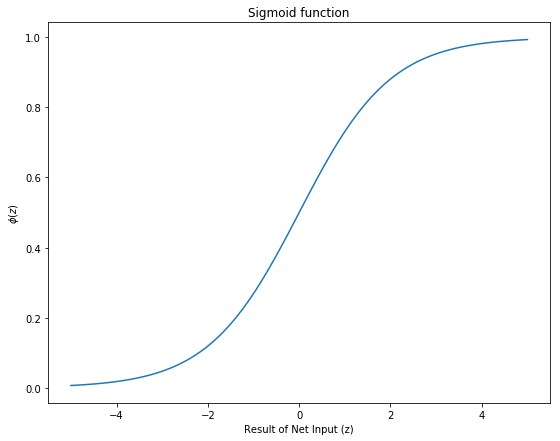

In [3]:
x = np.linspace(-5, 5, 100)
y = 1 / (1 + np.exp(-x))
fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(x, y)
ax.set_title("Sigmoid function")
ax.set_xlabel("Result of Net Input (z)")
ax.set_ylabel("$\phi(z)$")
plt.show()

Notice that the outputs vary between 0 and 1 now, not -1 and 1. So when we calculate the error term $(y_i - phi_z) for the gradient descent the value would be excessively wrong for y_i's that were -1.

In other words, we need to use target variables that are from 0 to 1.

In [4]:
iris = datasets.load_iris()
X, y = (iris.data[:100, [0, 2]], iris.target[:100])  # For simplicity, pick only two features and only two classes
X_std = np.copy(X)
X_std = StandardScaler().fit_transform(X_std)

To work with a sigmoid activation function we're going to have to change a few things.

First, the activation function now needs to be a sigmoid:

$\phi(z) = \frac{1}{1 + e^{-z}}$

Next, we need to update the update, since the derivitive of the cost function has changed:

$w_j = w_j + \Delta w_j = w_j - \eta \sum((y - \phi(z)) \cdot \phi(z) \cdot (1 - \phi(z)))x_j$

In other words, the update should now be:

`update = (y_i - phi_z) * phi_z * (1 - phi_z )`

Finally, since we've changed the scale of the target again (from zero to one) we need to alter the quantisation function to output a 0 when <= 0.5 and 1 when > 0.5

#### Hints:

- The error should be the difference between the real target and the value produced by the activation function. So in this case, the output from the sigmoid. In previous versions of the perceptron you might have skipped the activation function.
- The inputs need to be randomised or it will take longer for the data to converge. You might get different results each time if you don't use a np.random.seed(...)
- The scale of your target variable has changed. Be carful with the quantisation.
- Add some print()'s to debug

If all else fails, get some help! :-)

In [5]:
class SGD:
    def __init__(self, itr=10, eta=0.01) -> None:
        self.n_iterations = itr
        self.eta = eta

    def fit(self, X, y) -> None:
        self.w_ = np.zeros(X.shape[1] + 1)              # Add one for bias input (threshold)
        self.errors_ = np.zeros(self.n_iterations)      # Array for holding errors

        for i in range(self.n_iterations):              # Foreach iteration
            X, y = self._shuffle(X, y)                  # Randomise the data on each iteration
            for (x_i, y_i) in zip(X, y):                # Foreach training instance
                cost = self._update_weights(x_i, y_i)   # Update weights
                self.errors_[i] += cost                 # Add cost
            self.errors_[i] /= len(y)                   # Average cost per iteration

    def _update_weights(self, x_i, y_i):
        net_output = self.net_input(x_i)  # Output of net_input
        error = (y_i - net_output)
        cost = (error ** 2).sum() / 2.0  # Cost function

        # Update the weights. This is just linear gradient descent.
        self.w_[1:] += self.eta * x_i.T.dot(error)
        self.w_[0] += self.eta * error  # Update the bias weight
        return cost

    def partial_fit(self, X, y):
        X, y = self._shuffle(X, y)
        for (x_i, y_i) in zip(X, y):  # Foreach training instance
            self._update_weights(x_i, y_i)

    def activation(self, X):                            # Activation is just linear
        return self.net_input(X)                        #  combination, same as net_input

    def net_input(self, X):
        return np.dot(self.w_[1:].T, X) + self.w_[0]    # Sum of weighted inputs

    def predict(self, X):
        if self.activation(X) >= 0:                     # Quantiser
            return 1.0
        else:
            return -1.0

    def _shuffle(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]


class Sigmoid:
    def __init__(self, itr=50, eta=0.1) -> None:
        self.n_iterations = itr
        self.eta = eta

    def fit(self, X, y) -> None:
        self.w_ = np.zeros(X.shape[1] + 1)              # Add one for bias input (threshold)
        self.errors_ = np.zeros(self.n_iterations)      # Array for holding errors

        for i in range(self.n_iterations):              # Foreach iteration
            X, y = self._shuffle(X, y)                  # Randomise the data on each iteration
            for (x_i, y_i) in zip(X, y):                # Foreach training instance
                cost = self._update_weights(x_i, y_i)   # Update weights
                self.errors_[i] += cost                 # Add cost
            self.errors_[i] /= len(y)                   # Average cost per iteration

    def _update_weights(self, x_i, y_i):
        phi_z = self.activation(x_i)                    # Output of activation function
        error = (y_i - phi_z)
        cost = error ** 2 / 2                           # Cost is still MSE
        update = error * phi_z * (1 - phi_z )           # New update function for sigmoid

        # Update the weights. This is just linear gradient descent.
        self.w_[1:] += self.eta * x_i.T.dot(update)
        self.w_[0] += self.eta * update
        return cost

    def partial_fit(self, X, y):
        X, y = self._shuffle(X, y)
        for (x_i, y_i) in zip(X, y):  # Foreach training instance
            self._update_weights(x_i, y_i)

    def activation(self, X):
        net_exp = self.net_input(X)
        return self._sigmoid(net_exp)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def net_input(self, X):
        return np.dot(self.w_[1:].T, X) + self.w_[0]    # Sum of weighted inputs

    def predict(self, X):
        if self.activation(X) >= 0.5:                   # Quantiser changed for sigmoid
            return 1.0
        else:
            return 0

    def _shuffle(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]


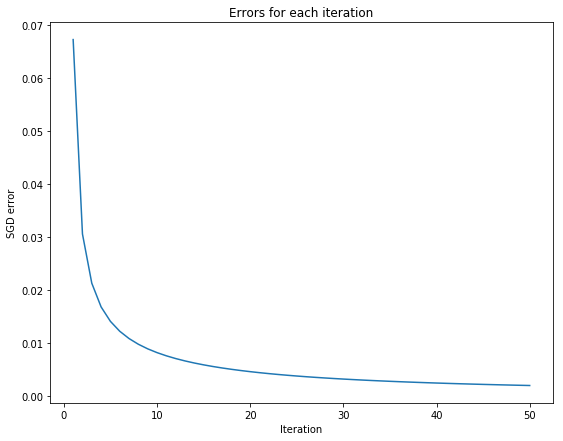

In [6]:
clf = Sigmoid(eta=0.1, itr=50)
clf.fit(X_std, y)
fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(range(1, len(clf.errors_) + 1), clf.errors_)
ax.set_title("Errors for each iteration")
ax.set_xlabel("Iteration")
ax.set_ylabel("SGD error")
plt.show()

Note how I have increased the learning rate and the number of iterations. This is required so that it converges. In fact, you can still see it decreasing after 50 iterations. This will be explained in the presentation.

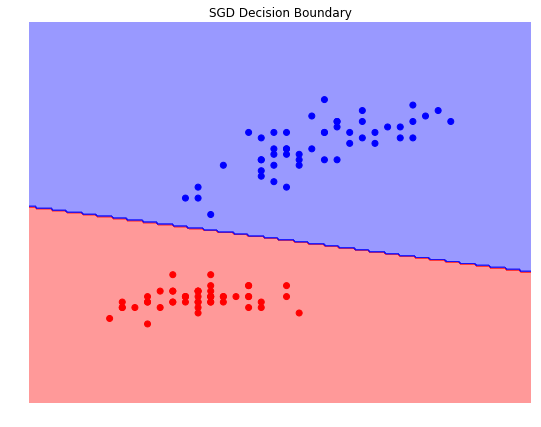

In [7]:
fig, ax = plt.subplots(figsize=(9, 7))
plot_decision(ax, clf, X_std)
plot_points(ax, X_std, y)
ax.set_axis_off()
ax.set_title("SGD Decision Boundary")
plt.show()